In [26]:
# === Librerías generales ===

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np


In [27]:
# === CONFIGURACIÓN GLOBAL ===
# Parámetros y constantes del proyecto
N_SPLITS = 5
N_ESTIMATORS = 100
METRICA_WEIGHTS = (0.55, 0.45)

In [28]:
# === BLOQUE 1: Cargar archivos ===

# Definir rutas absolutas de los archivos en el sistema local
ruta_dataset = r"encavi_reducido_convertido.csv"
ruta_diccionario = r"encavi_conversion_etiquetas_2025.csv"

# Leer el dataset original
df = pd.read_csv(ruta_dataset)

# Leer el diccionario con codificación adecuada y separador correcto
diccionario = pd.read_csv(ruta_diccionario, encoding="latin1", sep=";")

print(f"Dataset cargado con shape: {df.shape}")


Dataset cargado con shape: (7016, 63)


In [29]:
# === BLOQUE 2: Renombrar columnas según diccionario ===

# Crear un diccionario de mapeo: {nombre_original: traduccion}
mapeo_columnas = dict(zip(diccionario["ORIGINAL"], diccionario["TRADUCCION"]))

# Filtrar solo las columnas que están en el diccionario
df_filtrado = df[list(mapeo_columnas.keys())]

# Renombrar las columnas en el DataFrame filtrado
df_renombrado = df_filtrado.rename(columns=mapeo_columnas)

print("Columnas renombradas correctamente.")
df_renombrado.head()


Columnas renombradas correctamente.


,Sexo,Edad,hrs_trab,dom_trab,calidad_sueño,hrs_sueño,fam_hip,fam_dia,fam_car,fam_vas,...,pes,lac,baz,pan,agu,hip,dia,car,vas,res
0,H,38,48,1,2,7,0,0,0,0,...,1,2,6,6,2,0,0,0,0,0
1,M,48,40,1,2,6,0,0,0,0,...,1,3,5,6,7,1,0,0,0,0
2,H,38,36,0,2,6,0,0,0,0,...,1,1,2,3,1,0,0,0,1,0
3,M,59,70,0,2,6,1,0,0,0,...,1,6,7,7,7,1,0,0,0,0
4,M,60,0,0,2,7,0,0,0,0,...,1,5,6,7,7,1,0,0,0,0


In [49]:
# === Preprocesamiento: One-Hot Encoding ===

# Aplicar One-Hot Encoding a variables categóricas específicas
vars_categoricas = ['Sexo', 'fumador']
for var in vars_categoricas:
    if var in df_renombrado.columns:
        dummies = pd.get_dummies(df_renombrado[var], prefix=var, drop_first=True)
        df_renombrado = pd.concat([df_renombrado.drop(columns=var), dummies], axis=1)

# Imputar nulos en la variable 'horas_sentado_dia' con la moda si existe
if 'horas_sentado_dia' in df_renombrado.columns:
    moda_sentado = df_renombrado['horas_sentado_dia'].mode().dropna()
    if not moda_sentado.empty:
        df_renombrado['horas_sentado_dia'] = df_renombrado['horas_sentado_dia'].fillna(moda_sentado[0])

# Convertir floats que deberían ser enteros si no tienen decimales
for col in df_renombrado.select_dtypes(include='float64').columns:
    if (df_renombrado[col].dropna() % 1 == 0).all():
        df_renombrado[col] = df_renombrado[col].astype('Int64')

# Creamos una copia base para modelado. Aquí se pueden insertar columnas temporales
# (como probabilidades, predicciones, flags, etc.) sin alterar la versión procesada.
df_modelo = df_renombrado.copy()


print("One-Hot Encoding aplicado.")
df_renombrado.head()





One-Hot Encoding aplicado.


,Edad,hrs_trab,dom_trab,calidad_sueño,hrs_sueño,fam_hip,fam_dia,fam_car,fam_vas,fam_res,...,agu,hip,dia,car,vas,res,Sexo_M,fumador_2,fumador_3,fumador_4
0,38,48,1,2,7,0,0,0,0,0,...,2,0,0,0,0,0,False,False,False,True
1,48,40,1,2,6,0,0,0,0,0,...,7,1,0,0,0,0,True,False,False,True
2,38,36,0,2,6,0,0,0,0,0,...,1,0,0,0,1,0,False,False,False,True
3,59,70,0,2,6,1,0,0,0,0,...,7,1,0,0,0,0,True,False,False,False
4,60,0,0,2,7,0,0,0,0,0,...,7,1,0,0,0,0,True,False,False,True


In [51]:
# === BLOQUE 4: Análisis exploratorio ===


print("🔍 Información general del DataFrame:")
df_renombrado.info()

print("\n📊 Resumen estadístico:")
display(df_renombrado.describe(include='all'))

print("\n🧼 Valores nulos por columna:")
display(df_renombrado.isnull().sum().sort_values(ascending=False))


🔍 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7016 entries, 0 to 7015
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Edad                 7016 non-null   int64
 1   hrs_trab             7016 non-null   int64
 2   dom_trab             7016 non-null   int64
 3   calidad_sueño        7016 non-null   int64
 4   hrs_sueño            7016 non-null   int64
 5   fam_hip              7016 non-null   int64
 6   fam_dia              7016 non-null   int64
 7   fam_car              7016 non-null   int64
 8   fam_vas              7016 non-null   int64
 9   fam_res              7016 non-null   int64
 10  frec_desayuno        7016 non-null   int64
 11  frec_almuerzo        7016 non-null   int64
 12  frec_once            7016 non-null   int64
 13  frec_cena            7016 non-null   int64
 14  exp_cigarro_hogar    7016 non-null   int64
 15  exp_cigarro_trab     7016 non-null 

,Edad,hrs_trab,dom_trab,calidad_sueño,hrs_sueño,fam_hip,fam_dia,fam_car,fam_vas,fam_res,...,agu,hip,dia,car,vas,res,Sexo_M,fumador_2,fumador_3,fumador_4
count,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,...,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016.000000,7016,7016,7016,7016
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4399,6000,6672,3819
mean,47.169897,19.620011,0.382982,2.177879,7.241306,0.238597,0.131556,0.034208,0.025798,0.093786,...,6.227195,0.295182,0.148090,0.036345,0.028079,0.064994,NaN,NaN,NaN,NaN
std,18.600338,23.656435,0.941778,1.018713,1.593754,0.426257,0.338032,0.181775,0.158544,0.291551,...,1.834874,0.456157,0.355215,0.187162,0.165209,0.246533,NaN,NaN,NaN,NaN
min,15.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,32.000000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,47.000000,0.000000,0.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,62.000000,45.000000,0.000000,2.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN



🧼 Valores nulos por columna:


Edad                   0
agu                    0
ver                    0
leg                    0
fru                    0
pes                    0
lac                    0
baz                    0
pan                    0
hip                    0
hrs_trab               0
dia                    0
car                    0
vas                    0
res                    0
Sexo_M                 0
fumador_2              0
fumador_3              0
horas_sentado_dia      0
dias_caminata          0
dias_act_fisica_mod    0
dias_act_fisica_int    0
dom_trab               0
calidad_sueño          0
hrs_sueño              0
fam_hip                0
fam_dia                0
fam_car                0
fam_vas                0
fam_res                0
frec_desayuno          0
frec_almuerzo          0
frec_once              0
frec_cena              0
exp_cigarro_hogar      0
exp_cigarro_trab       0
frec_alcohol           0
fumador_4              0
dtype: int64

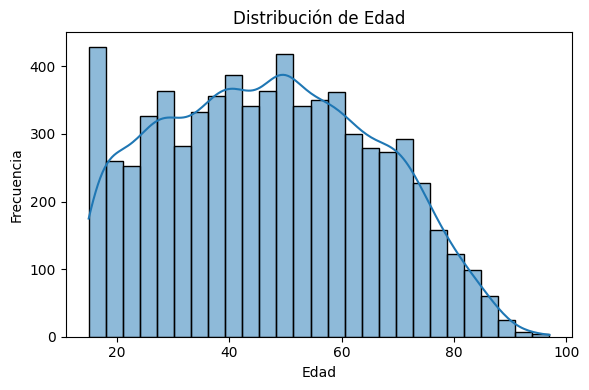

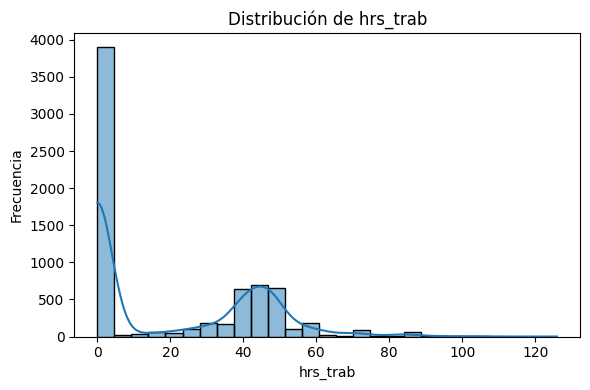

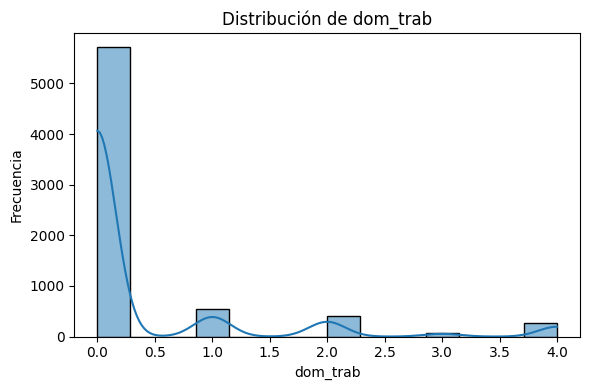

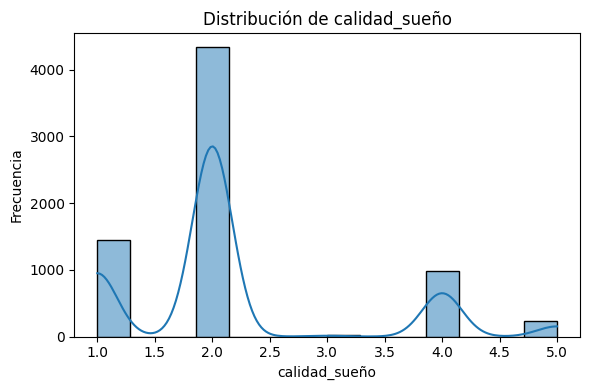

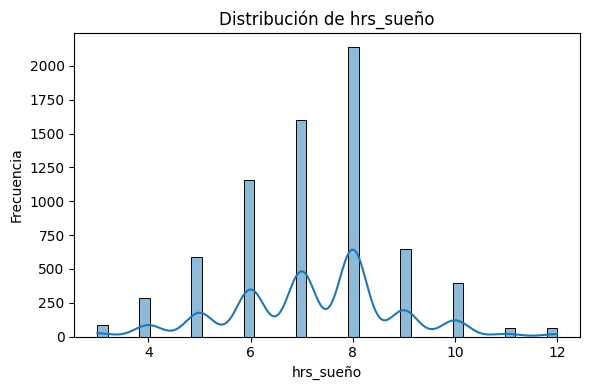

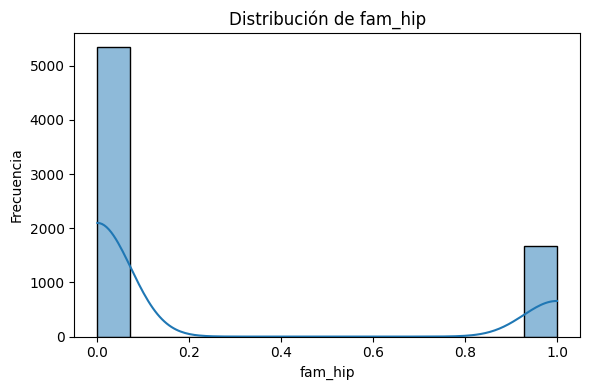

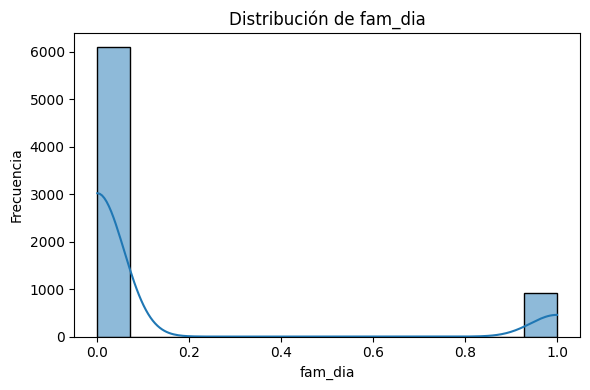

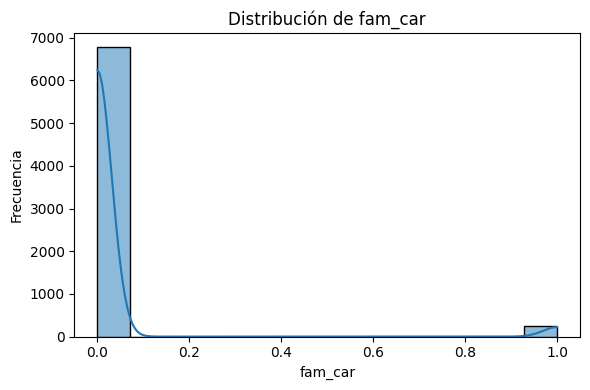

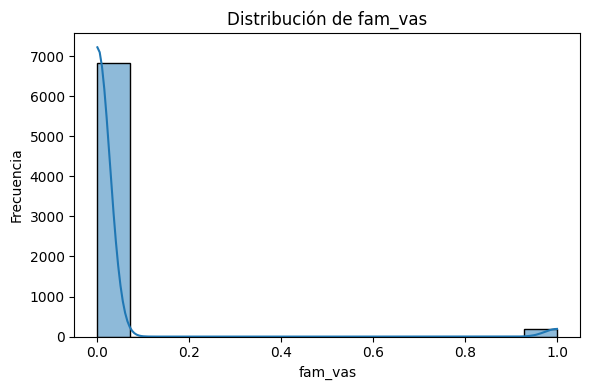

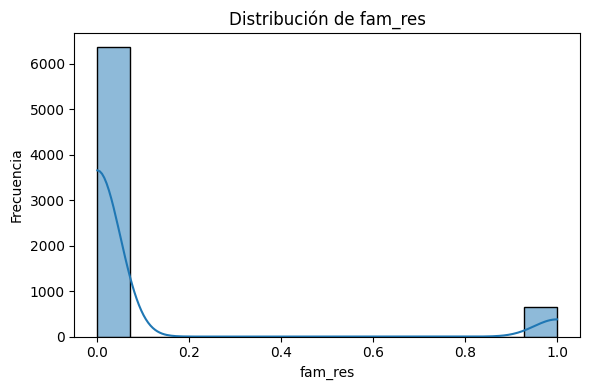

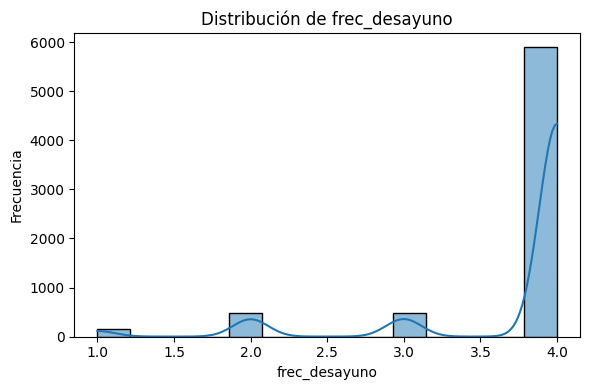

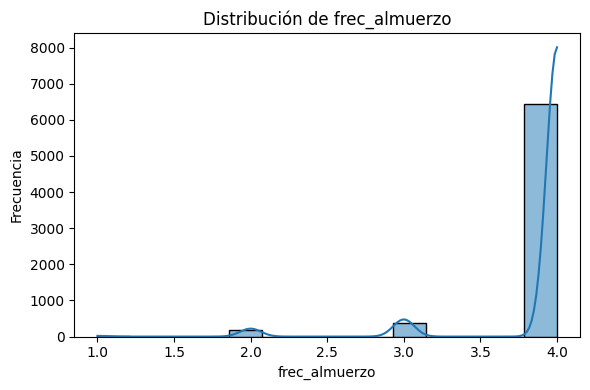

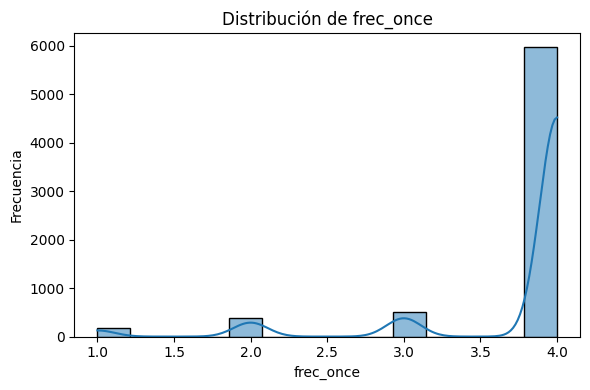

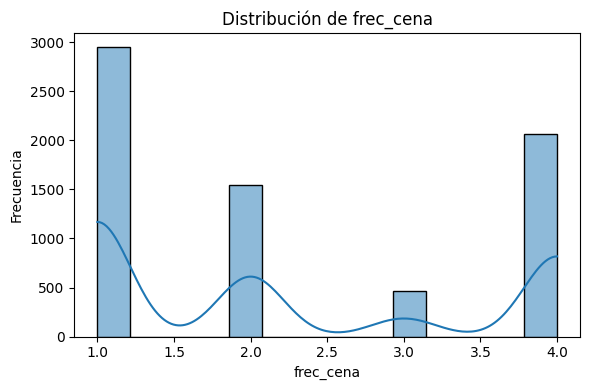

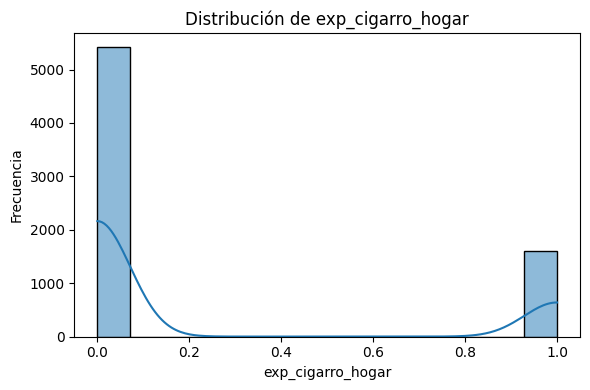

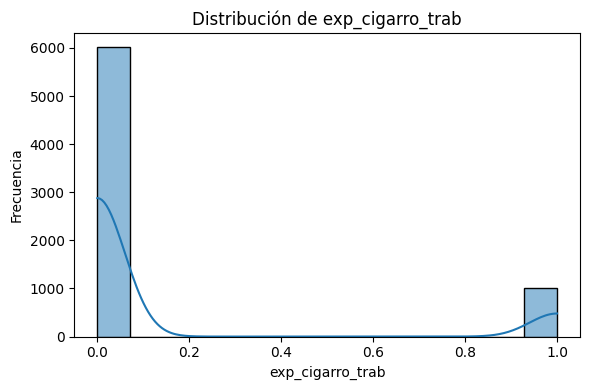

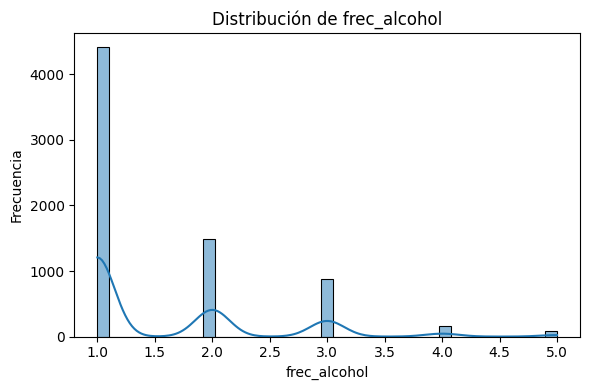

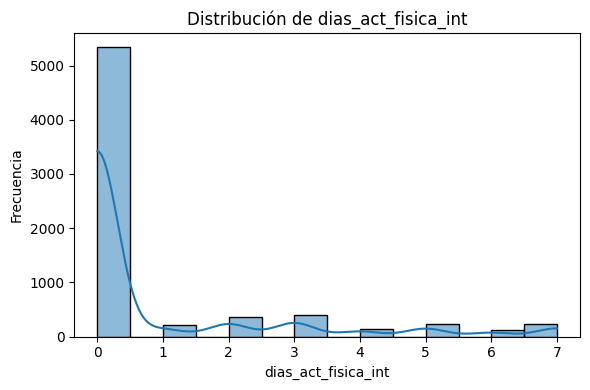

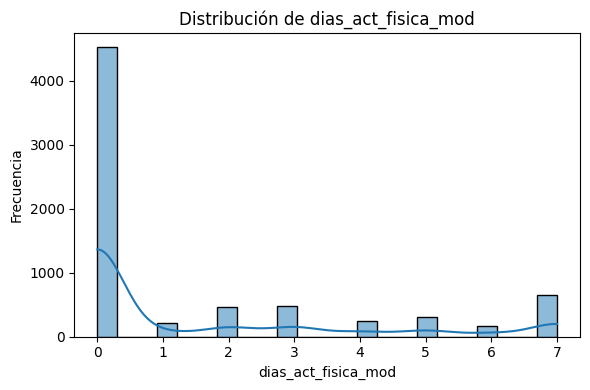

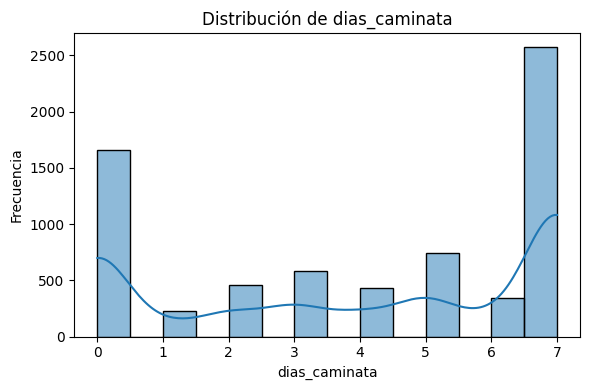

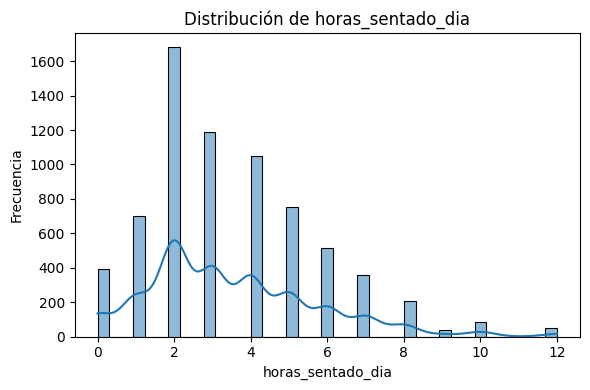

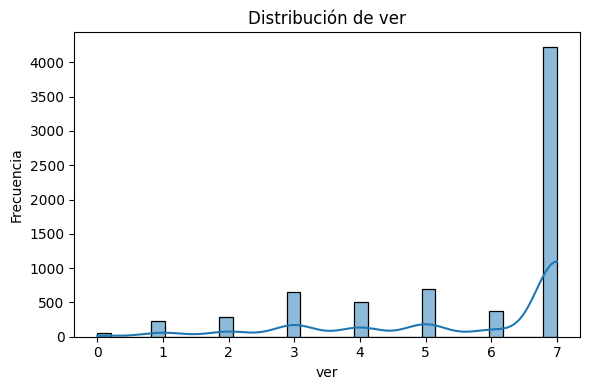

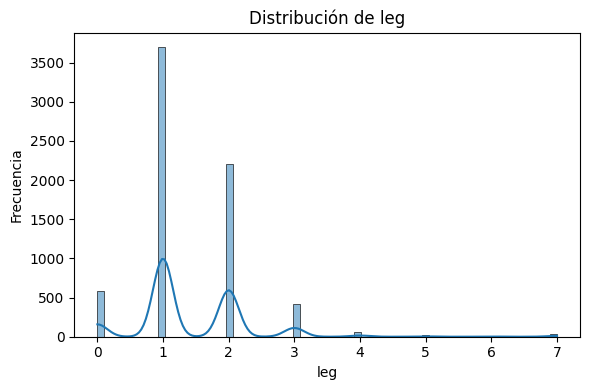

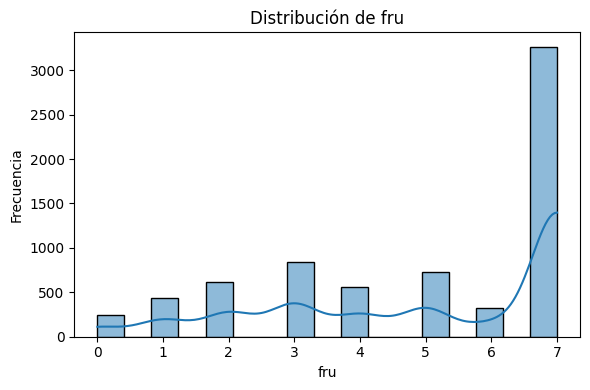

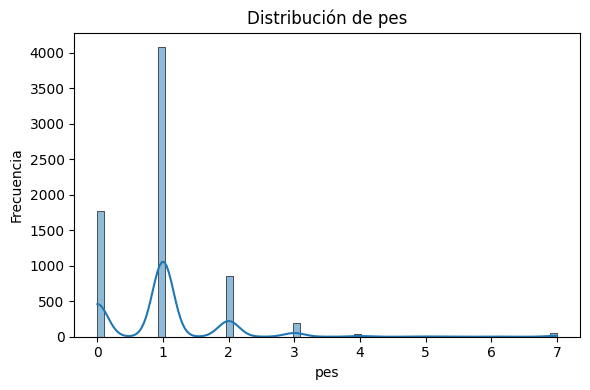

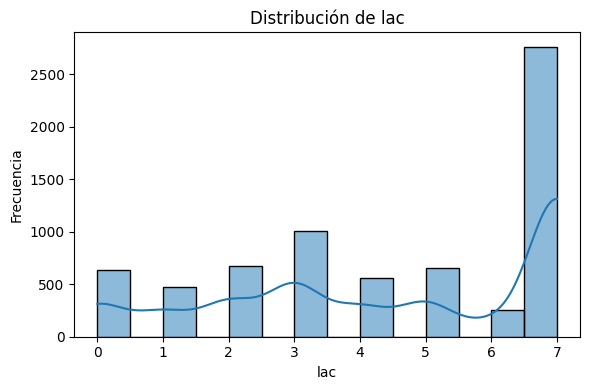

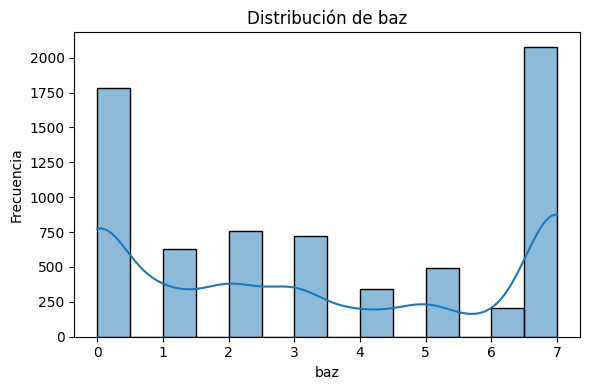

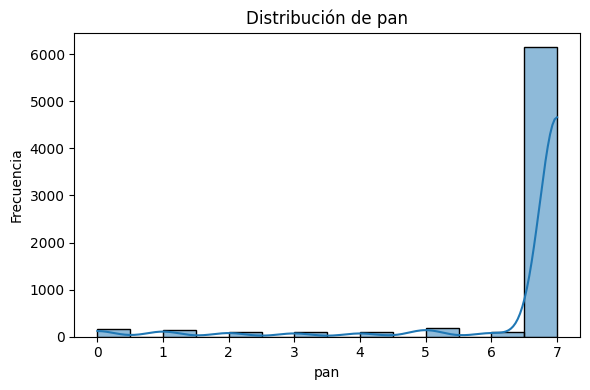

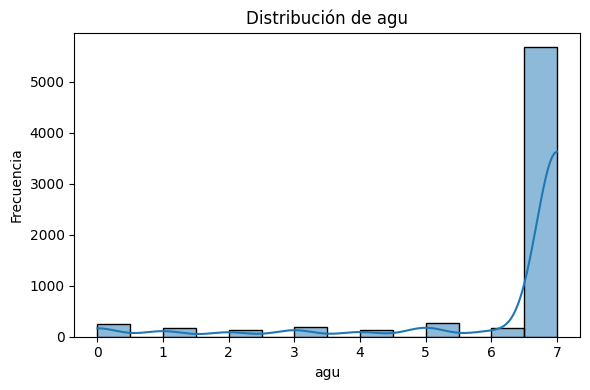

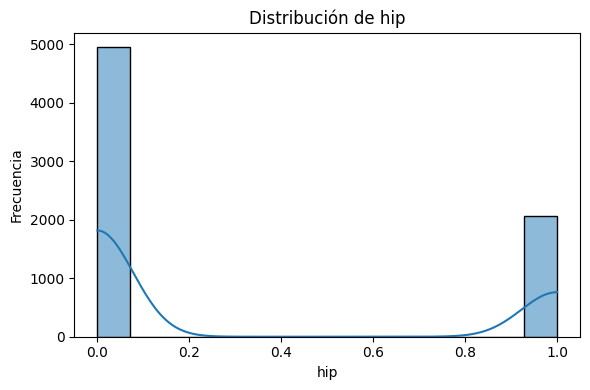

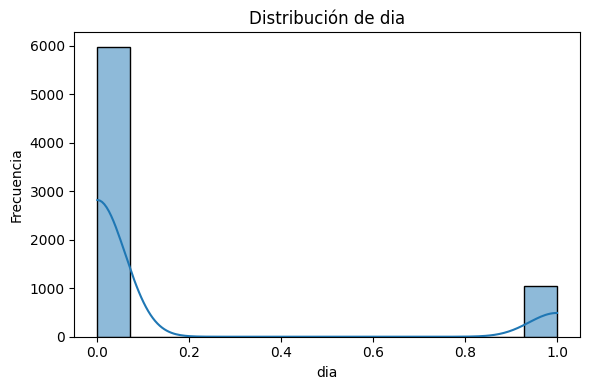

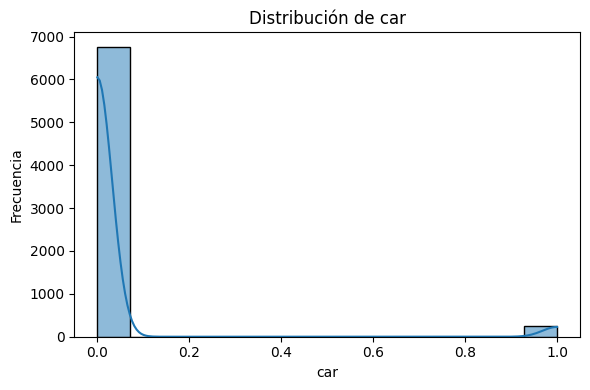

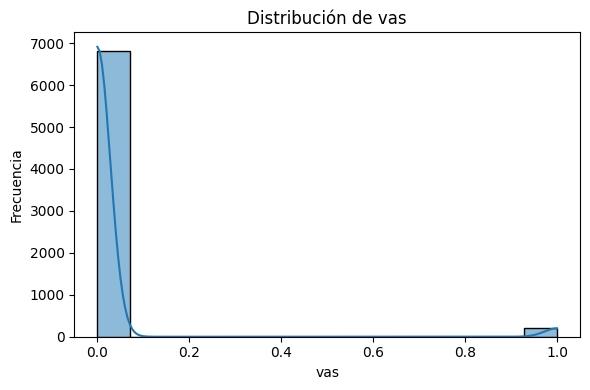

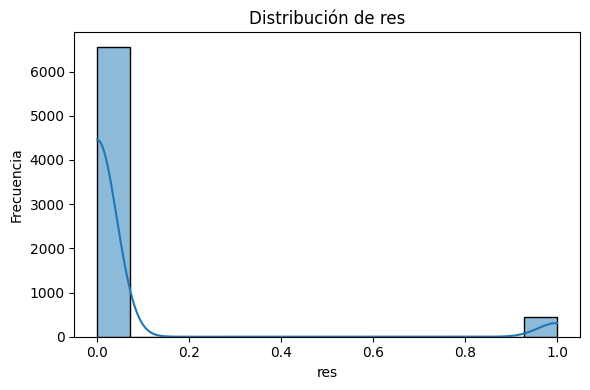

In [53]:

# === BLOQUE 5: Visualización - Histogramas ===

num_cols = df_renombrado.select_dtypes(include=['float64', 'int64', 'Int64']).columns
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_renombrado[col].dropna(), kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

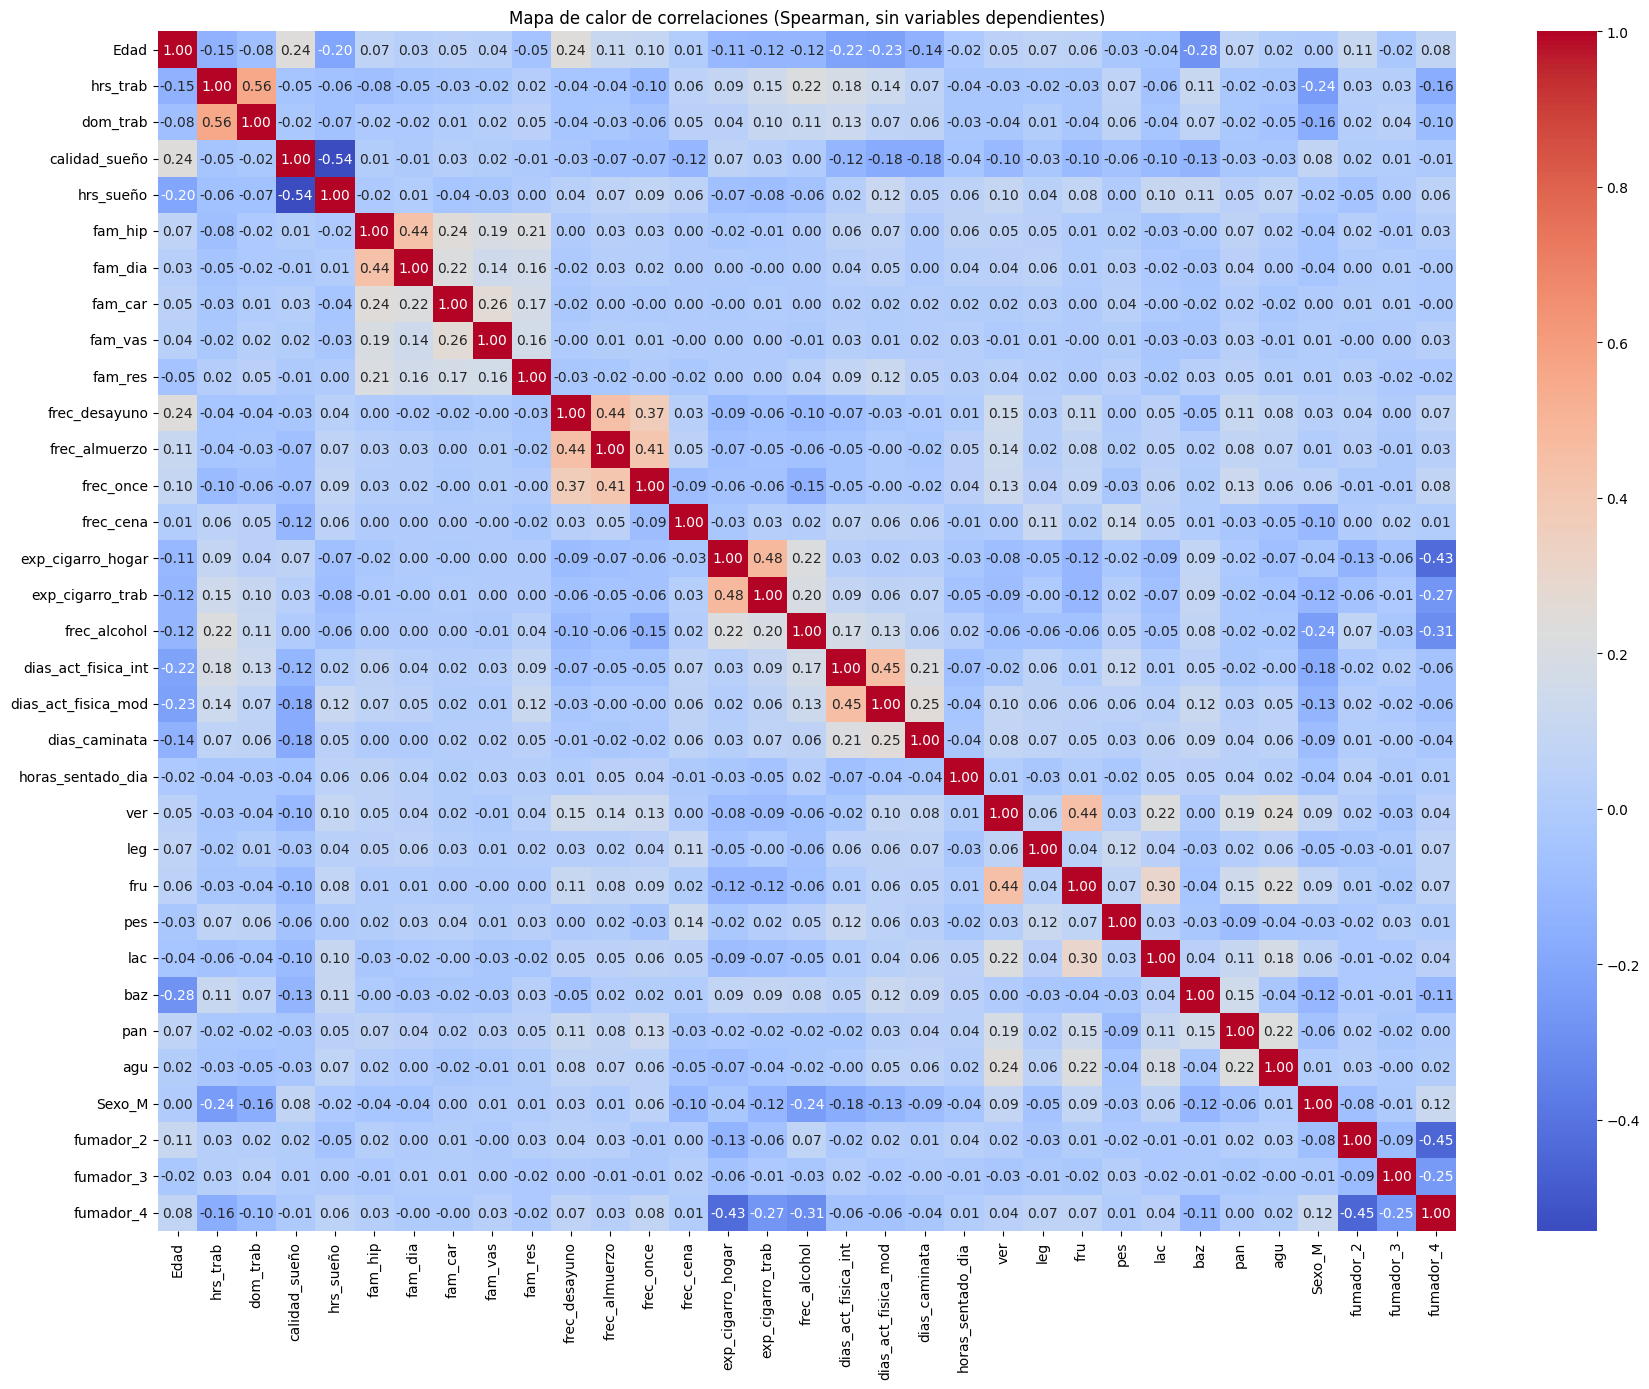

In [54]:
# === BLOQUE 6: Visualización - Correlación ===


# Calcular y mostrar el mapa de calor de correlaciones usando Spearman
# Excluir variables dependientes antes del cálculo
dependientes = ['hip', 'dia', 'car', 'vas', 'res']
df_corr = df_renombrado.drop(columns=[col for col in dependientes if col in df_renombrado.columns])

# Seleccionar columnas numéricas y booleanas para correlación
num_corr_cols = df_corr.select_dtypes(include=['float64', 'int64', 'Int64', 'bool']).columns

# Calcular y mostrar el mapa de calor con método Spearman
if len(num_corr_cols) > 1:
    plt.figure(figsize=(18, 14))
    sns.heatmap(df_corr[num_corr_cols].corr(method='spearman'), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Mapa de calor de correlaciones (Spearman, sin variables dependientes)")
    plt.tight_layout()
    plt.show()


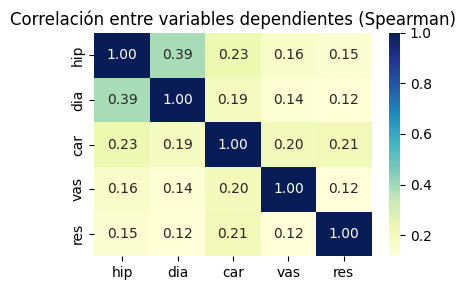

In [57]:
# === BLOQUE 6B: Correlación entre variables dependientes ===

variables_dependientes = ['hip', 'dia', 'car', 'vas', 'res']
df_dependientes = df_renombrado[variables_dependientes].copy()

plt.figure(figsize=(4, 3))
sns.heatmap(df_dependientes.corr(method='spearman'), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlación entre variables dependientes (Spearman)")
plt.tight_layout()
plt.show()

### Vamos a avanzar directamente con las variables sin considerar los factores dado
### el test  Kaiser-Meyer-Olkin (KMO) = 0.6023

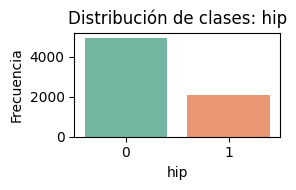

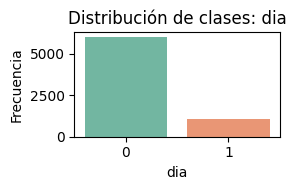

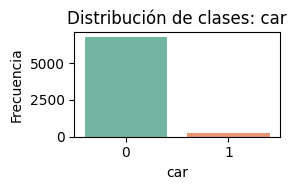

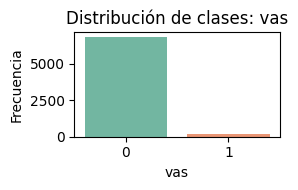

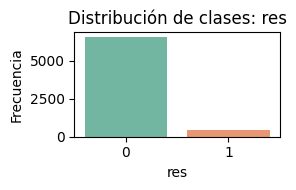


Distribución de clases en variables dependientes:

hip:
hip
0    0.705
1    0.295
Name: proportion, dtype: float64

dia:
dia
0    0.852
1    0.148
Name: proportion, dtype: float64

car:
car
0    0.964
1    0.036
Name: proportion, dtype: float64

vas:
vas
0    0.972
1    0.028
Name: proportion, dtype: float64

res:
res
0    0.935
1    0.065
Name: proportion, dtype: float64


In [60]:
# === BLOQUE 7: Análisis de desbalance en variables dependientes ===

for var in variables_dependientes:
    if var in df_renombrado.columns:
        plt.figure(figsize=(3, 2))
        sns.countplot(x=var, data=df_renombrado, hue=var, palette="Set2", legend=False)
        plt.title(f"Distribución de clases: {var}")
        plt.xlabel(var)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

print("\nDistribución de clases en variables dependientes:")
for var in variables_dependientes:
    if var in df_renombrado.columns:
        print(f"\n{var}:")
        print(df_renombrado[var].value_counts(normalize=True).round(3))


In [62]:
# === BLOQUE 8: Métrica personalizada para clasificación binaria ===

# Contexto: esta métrica favorece la detección de verdaderos positivos (TPR)
# sacrificando ligeramente los falsos positivos, útil para detección temprana
# de enfermedades en salud pública.

def calcular_metrica_personalizada(y_true, y_prob, threshold):
    y_pred = (y_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    custom_score = 0.55 * tpr + 0.45 * tnr
    return custom_score


In [64]:

# === BLOQUE 9: Entrenamiento con SMOTE y Random Forest por fold ===
# Entrena un modelo en un fold aplicando SMOTE y ajusta el threshold usando la métrica personalizada
def entrenar_con_smote_fold(X, y, train_index, test_index, n_neighbors=5, dup_size=1, n_estimators=100):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    smote = SMOTE(k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train.astype('float64'), y_train)
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_resampled, y_resampled)
    y_prob = model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.0, 1.005, 0.005)
    scores = [calcular_metrica_personalizada(y_test, y_prob, thr) for thr in thresholds]
    best_index = int(np.argmax(scores))
    best_threshold = thresholds[best_index]
    y_pred_final = (y_prob > best_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_final)
    return {
        'modelo': model,
        'confusion_matrix': cm,
        'mejor_threshold': best_threshold,
        'custom_score': scores[best_index]
    }

In [66]:
# === BLOQUE 10: Validación cruzada con SMOTE y Random Forest ===
# Ejecuta entrenamiento y evaluación por fold usando StratifiedKFold
def validacion_cruzada_modelo(X, y, n_splits=5, n_neighbors=5, dup_size=1, n_estimators=100):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    resultados = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"Entrenando fold {fold}...")
        resultado = entrenar_con_smote_fold(
            X, y,
            train_index=train_idx,
            test_index=test_idx,
            n_neighbors=n_neighbors,
            dup_size=dup_size,
            n_estimators=n_estimators
        )
        resultados.append(resultado)
    return resultados


## Proceso para Enfermedad Cardiaca , variable "car"

In [69]:
# === BLOQUE 11: Validación cruzada para enfermedad cardíaca (car) ===

# Seleccionar X (variables independientes) e y (variable objetivo)
X_car = df_renombrado.drop(columns=variables_dependientes)
y_car = df_renombrado['car']

# Ejecutar validación cruzada
resultados_car = validacion_cruzada_modelo(
    X_car, y_car,
    n_splits=5,
    n_neighbors=round(np.sqrt(y_car.sum())),  # heurística para SMOTE
    dup_size=20,
    n_estimators=100
)

# Extraer métricas de cada fold
from sklearn.metrics import precision_score, f1_score
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)

sensitividades_car = []
precisiones_car = []
f1_scores_car = []

resultados_completos_car = []  # Para guardar resultados por fold

for i, res in enumerate(resultados_car):
    cm = res['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()

    # TPR: Sensibilidad (Recall)
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    # TNR: Especificidad
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Precision: Qué tan confiables son los positivos
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # F1-score: balance entre precisión y recall
    f1 = 2 * (precision * sensibilidad) / (precision + sensibilidad) if (precision + sensibilidad) > 0 else 0

    sensitividades_car.append(sensibilidad)
    precisiones_car.append(precision)
    f1_scores_car.append(f1)

    logging.info(f"Fold {i+1}: TPR={sensibilidad:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Th={res['mejor_threshold']:.2f}")

    resultados_completos_car.append({
        'fold': i+1,
        'confusion_matrix': cm,
        'TPR': sensibilidad,
        'Precision': precision,
        'F1': f1,
        'Threshold': res['mejor_threshold']
    })
print(f"TPR prom. car: {np.mean(sensitividades_car):.3f}")
print(f"Precisión prom. car: {np.mean(precisiones_car):.3f}")
print(f"F1-score prom. car: {np.mean(f1_scores_car):.3f}")


Entrenando fold 1...
Entrenando fold 2...
Entrenando fold 3...
Entrenando fold 4...
Entrenando fold 5...


INFO:root:Fold 1: TPR=0.941, Precision=0.076, F1=0.140, Th=0.05
INFO:root:Fold 2: TPR=0.882, Precision=0.091, F1=0.165, Th=0.07
INFO:root:Fold 3: TPR=0.725, Precision=0.123, F1=0.211, Th=0.11
INFO:root:Fold 4: TPR=0.804, Precision=0.094, F1=0.169, Th=0.08
INFO:root:Fold 5: TPR=0.706, Precision=0.083, F1=0.148, Th=0.07


TPR prom. car: 0.812
Precisión prom. car: 0.093
F1-score prom. car: 0.166


In [71]:
# === BLOQUE 12: Entrenamiento final con todos los datos y guardado del modelo ===
# Función auxiliar para entrenar un modelo completo con SMOTE
from joblib import dump

def entrenar_modelo_final(X, y, n_neighbors=5, n_estimators=100):
    smote = SMOTE(k_neighbors=n_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X.astype('float64'), y)
    modelo = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    modelo.fit(X_resampled, y_resampled)
    return modelo

modelo_final_car = entrenar_modelo_final(
    X_car,
    y_car,
    n_neighbors=round(np.sqrt(y_car.sum())),
    n_estimators=N_ESTIMATORS
)

# Calcular el threshold promedio de los mejores thresholds de cada fold
threshold_promedio_car = np.mean([r['mejor_threshold'] for r in resultados_car])

# Guardar modelo junto con el threshold
ruta_modelo_car = "modelo_final_car.pkl"
modelo_guardado = {"modelo": modelo_final_car, "threshold": threshold_promedio_car}
dump(modelo_guardado, ruta_modelo_car)
print(f"Modelo final para 'car' guardado en: {ruta_modelo_car}")

Modelo final para 'car' guardado en: modelo_final_car.pkl


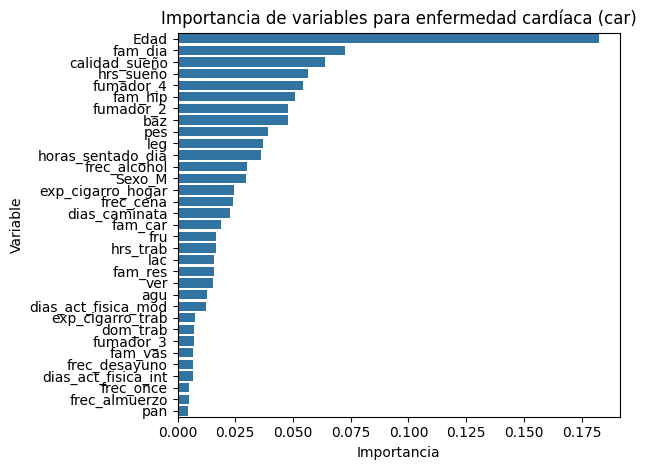

In [73]:
# === BLOQUE 13: Importancia de variables ===
importancias = modelo_final_car.feature_importances_
features = X_car.columns
importancia_df = pd.DataFrame({'Variable': features, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

sns.barplot(x='Importancia', y='Variable', data=importancia_df)
plt.title('Importancia de variables para enfermedad cardíaca (car)')
plt.tight_layout()
plt.show()


=== Evaluación del modelo final con todos los datos: enfermedad cardíaca (car) ===
              precision    recall  f1-score   support

           0      1.000     0.920     0.958      6761
           1      0.319     1.000     0.484       255

    accuracy                          0.922      7016
   macro avg      0.660     0.960     0.721      7016
weighted avg      0.975     0.922     0.941      7016



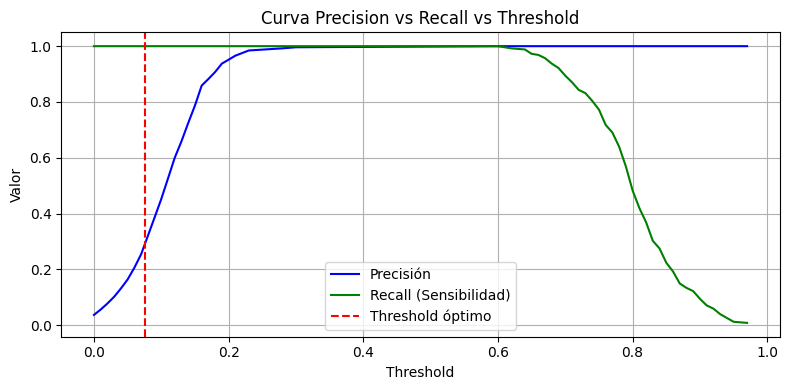

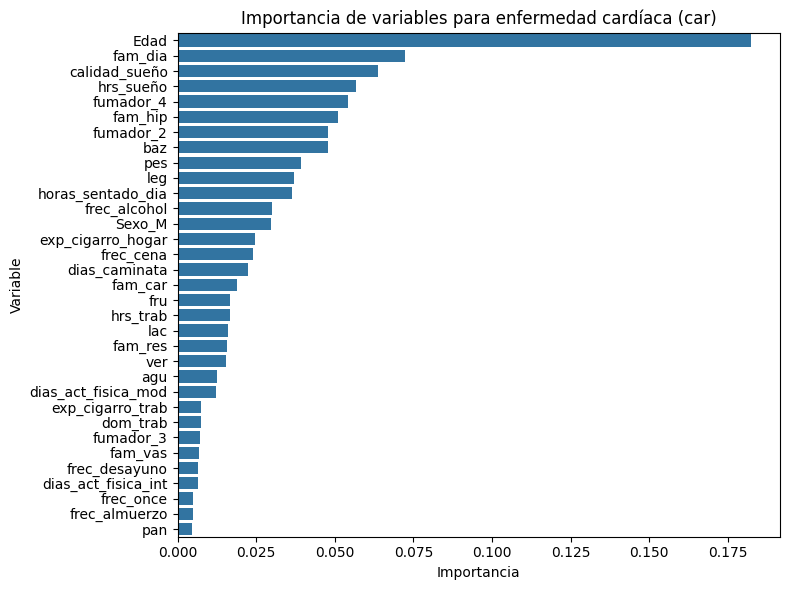

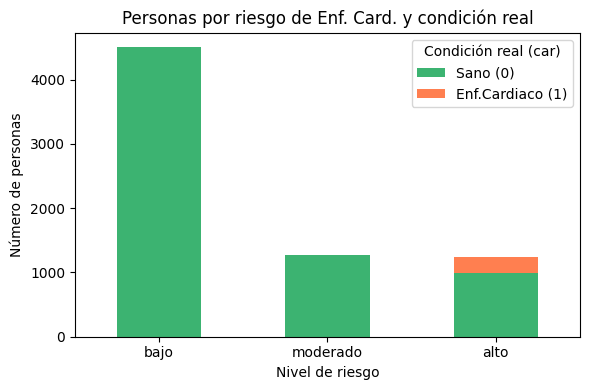

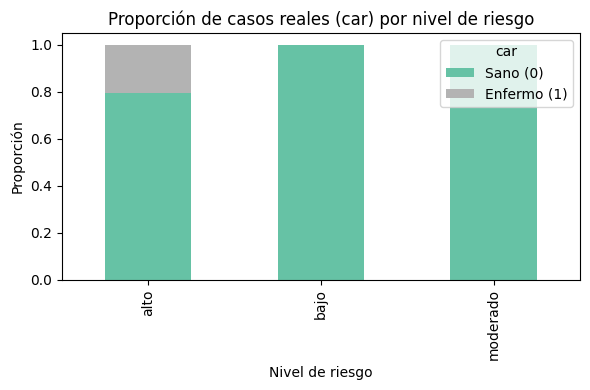

In [75]:
# === BLOQUE 14car: Evaluación del modelo final en todo el dataset ===

from sklearn.metrics import classification_report, precision_recall_curve

# Predecir probabilidades sobre todo el dataset para 'car'
probabilidades_car = modelo_guardado['modelo'].predict_proba(X_car)[:, 1]

# Clasificación por nivel de riesgo para enfermedad cardíaca
# Bajo: p < 0.03 | Moderado: 0.03 ≤ p < 0.06 | Alto: p ≥ 0.06
def clasificar_riesgo(prob):
    if prob < 0.03:
        return 'bajo'
    elif prob < 0.06:
        return 'moderado'
    else:
        return 'alto'

df_modelo['riesgo_car'] = [clasificar_riesgo(p) for p in probabilidades_car]

# Usar threshold promedio para clasificar
predicciones_finales_car = (probabilidades_car > modelo_guardado['threshold']).astype(int)

# Evaluar y mostrar métricas finales
print("\n=== Evaluación del modelo final con todos los datos: enfermedad cardíaca (car) ===")
print(classification_report(y_car, predicciones_finales_car, digits=3))

# === Curva Precision-Recall vs Threshold ===
precision, recall, thresholds = precision_recall_curve(y_car, probabilidades_car)
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precision[:-1], label='Precisión', color='b')
plt.plot(thresholds, recall[:-1], label='Recall (Sensibilidad)', color='g')
plt.axvline(modelo_guardado['threshold'], color='r', linestyle='--', label='Threshold óptimo')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Curva Precision vs Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Visualización de importancia de variables ===
importancias = modelo_final_car.feature_importances_
features = X_car.columns
importancia_df = pd.DataFrame({'Variable': features, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importancia', y='Variable', data=importancia_df)
plt.title('Importancia de variables para enfermedad cardíaca (car)')
plt.tight_layout()
plt.show()

# === Visualización de clases de riesgo + clase real ===
import matplotlib.pyplot as plt
import pandas as pd

# Orden de niveles de riesgo
orden_riesgo = ['bajo', 'moderado', 'alto']

# Crear tabla cruzada (conteo de personas por riesgo y clase real)
conteo = df_modelo.groupby(['riesgo_car', 'car']).size().unstack(fill_value=0).reindex(orden_riesgo)

# Gráfico de barras apiladas
conteo.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4),
    color=['mediumseagreen', 'coral']
)

# Títulos y etiquetas
plt.title('Personas por riesgo de Enf. Card. y condición real')
plt.xlabel('Nivel de riesgo')
plt.ylabel('Número de personas')
plt.legend(title='Condición real (car)', labels=['Sano (0)', 'Enf.Cardiaco (1)'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# === Visualización porcentual por clase real ===
porcentaje_riesgo = df_modelo.groupby('riesgo_car')['car'].value_counts(normalize=True).unstack().fillna(0)
porcentaje_riesgo.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='Set2')
plt.title('Proporción de casos reales (car) por nivel de riesgo')
plt.xlabel('Nivel de riesgo')
plt.ylabel('Proporción')
plt.legend(title='car', labels=['Sano (0)', 'Enfermo (1)'])
plt.tight_layout()
plt.show()




## Proceso para Hipertension , variable "hip"

In [78]:
# === BLOQUE 11 hip: Validación cruzada para hipertensión  (hip) ===

# Seleccionar X (variables independientes) e y (variable objetivo)
X_hip = df_renombrado.drop(columns=variables_dependientes)
y_hip = df_renombrado['hip']

# Ejecutar validación cruzada
resultados_hip = validacion_cruzada_modelo(
    X_hip, y_hip,
    n_splits=5,
    n_neighbors=round(np.sqrt(y_hip.sum())),  # heurística para SMOTE
    dup_size=20,
    n_estimators=100
)

# Extraer métricas de cada fold
from sklearn.metrics import precision_score, f1_score
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)

sensitividades_hip = []
precisiones_hip = []
f1_scores_hip = []

resultados_completos_hip = []  # Para guardar resultados por fold

for i, res in enumerate(resultados_hip):
    cm = res['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()

    # TPR: Sensibilidad (Recall)
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    # TNR: Especificidad
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Precision: Qué tan confiables son los positivos
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # F1-score: balance entre precisión y recall
    f1 = 2 * (precision * sensibilidad) / (precision + sensibilidad) if (precision + sensibilidad) > 0 else 0

    sensitividades_hip.append(sensibilidad)
    precisiones_hip.append(precision)
    f1_scores_hip.append(f1)

    logging.info(f"Fold {i+1}: TPR={sensibilidad:.3f}, Precision={precision:.3f}, F1={f1:.3f}, Th={res['mejor_threshold']:.2f}")

    resultados_completos_hip.append({
        'fold': i+1,
        'confusion_matrix': cm,
        'TPR': sensibilidad,
        'Precision': precision,
        'F1': f1,
        'Threshold': res['mejor_threshold']
    })
print(f"TPR prom. hip: {np.mean(sensitividades_hip):.3f}")
print(f"Precisión prom. hip: {np.mean(precisiones_hip):.3f}")
print(f"F1-score prom. hip: {np.mean(f1_scores_hip):.3f}")


Entrenando fold 1...
Entrenando fold 2...
Entrenando fold 3...
Entrenando fold 4...
Entrenando fold 5...


INFO:root:Fold 1: TPR=0.851, Precision=0.542, F1=0.662, Th=0.27
INFO:root:Fold 2: TPR=0.877, Precision=0.576, F1=0.695, Th=0.31
INFO:root:Fold 3: TPR=0.836, Precision=0.560, F1=0.671, Th=0.31
INFO:root:Fold 4: TPR=0.821, Precision=0.573, F1=0.675, Th=0.33
INFO:root:Fold 5: TPR=0.826, Precision=0.528, F1=0.644, Th=0.30


TPR prom. hip: 0.842
Precisión prom. hip: 0.556
F1-score prom. hip: 0.670


In [80]:
# === BLOQUE 12 generico : Entrenamiento final con todos los datos y guardado del modelo ===
# Función auxiliar para entrenar un modelo completo con SMOTE

from joblib import dump
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

def entrenar_y_guardar_modelo_final(df, variable_objetivo, variables_dependientes, resultados_dict, n_estimators=100):
    """
    Entrena un modelo RandomForest con SMOTE y guarda el modelo con el threshold promedio.

    Args:
        df: DataFrame con los datos.
        variable_objetivo: str, nombre de la variable dependiente (ej. 'car', 'hip').
        variables_dependientes: lista de columnas a excluir de X (target y otras).
        resultados_dict: diccionario con resultados de validación cruzada (por fold).
        n_estimators: cantidad de árboles del RandomForest.
    """
    # Preparar X e y
    X = df.drop(columns=variables_dependientes)
    y = df[variable_objetivo]

    # Aplicar SMOTE
    smote = SMOTE(k_neighbors=round(np.sqrt(y.sum())))
    X_resampled, y_resampled = smote.fit_resample(X.astype('float64'), y)

    # Entrenar modelo
    modelo = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    modelo.fit(X_resampled, y_resampled)

    # Calcular threshold promedio
    threshold_promedio = np.mean([r["mejor_threshold"] for r in resultados_dict])

    # Guardar modelo
    nombre = f"modelo_final_{variable_objetivo}"
    dump({"modelo": modelo, "threshold": threshold_promedio}, f"{nombre}.pkl")
    print(f"Modelo final para '{variable_objetivo}' guardado en: {nombre}.pkl")

    return modelo
    


In [82]:
modelo_hip = entrenar_y_guardar_modelo_final(
    df=df_renombrado,
    variable_objetivo='hip',
    variables_dependientes=variables_dependientes, 
    resultados_dict=resultados_hip,
    n_estimators=N_ESTIMATORS
)


Modelo final para 'hip' guardado en: modelo_final_hip.pkl


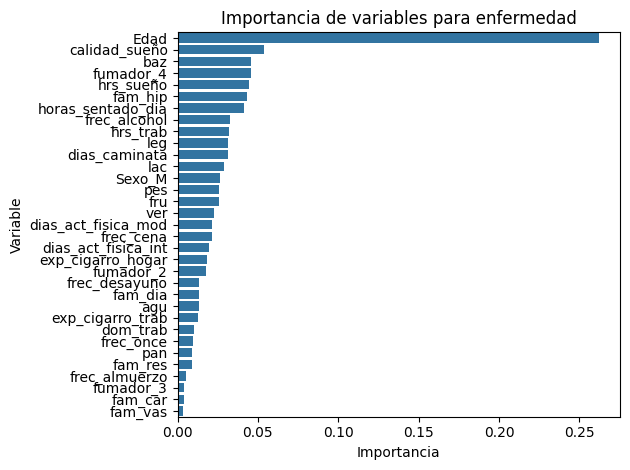

In [84]:
# === BLOQUE 13 hip: Importancia de variables ===
importancias = modelo_hip.feature_importances_
features = X_hip.columns
importancia_df = pd.DataFrame({'Variable': features, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

sns.barplot(x='Importancia', y='Variable', data=importancia_df)
plt.title('Importancia de variables para enfermedad')
plt.tight_layout()
plt.show()

In [86]:
from joblib import load
modelo_guardado_hip = load("modelo_final_hip.pkl")



=== Evaluación del modelo final con todos los datos: hipertensión (hip) ===
              precision    recall  f1-score   support

           0      1.000     0.985     0.992      4945
           1      0.966     1.000     0.982      2071

    accuracy                          0.989      7016
   macro avg      0.983     0.993     0.987      7016
weighted avg      0.990     0.989     0.990      7016



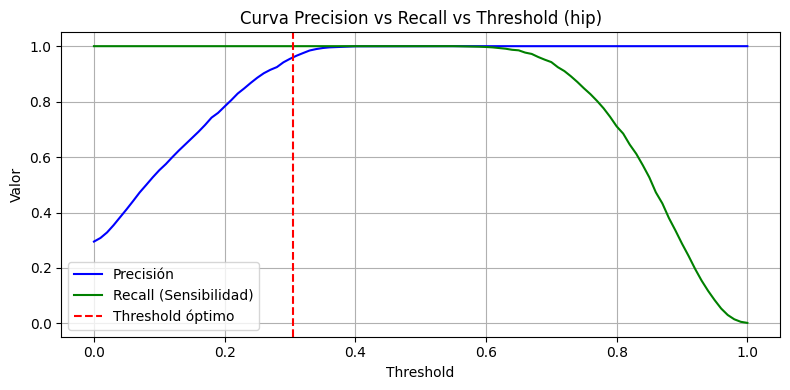

Threshold optimo:0.30400000000000005


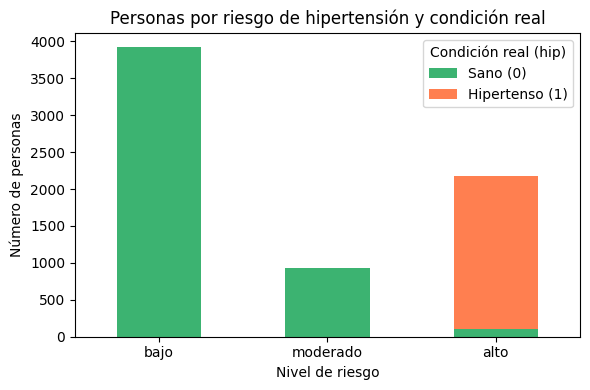

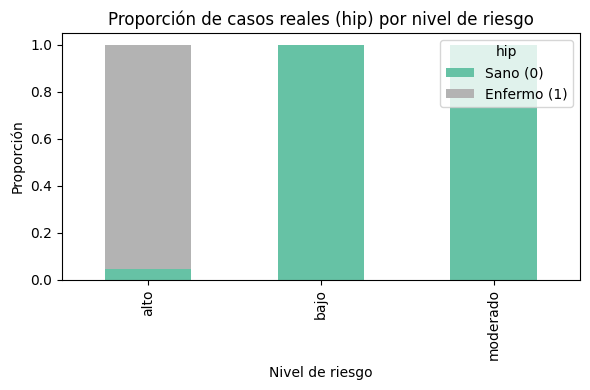

In [88]:
# === BLOQUE 14 hip: Evaluación del modelo final en todo el dataset ===

from sklearn.metrics import classification_report, precision_recall_curve

# Predecir probabilidades sobre todo el dataset para 'hip'
probabilidades_hip = modelo_hip.predict_proba(X_hip)[:, 1]

# Clasificación por nivel de riesgo para hipertensión basada en probabilidades
def clasificar_riesgo_hip(prob):
    if prob < 0.15:
        return 'bajo'
    elif prob < 0.30:
        return 'moderado'
    else:
        return 'alto'


df_modelo['riesgo_hip'] = [clasificar_riesgo_hip(p) for p in probabilidades_hip]

# Usar threshold promedio para clasificar
predicciones_finales_hip = (probabilidades_hip > modelo_guardado_hip['threshold']).astype(int)

# Evaluar y mostrar métricas finales
print("\n=== Evaluación del modelo final con todos los datos: hipertensión (hip) ===")
print(classification_report(y_hip, predicciones_finales_hip, digits=3))

# === Curva Precision-Recall vs Threshold ===
precision, recall, thresholds = precision_recall_curve(y_hip, probabilidades_hip)
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precision[:-1], label='Precisión', color='b')
plt.plot(thresholds, recall[:-1], label='Recall (Sensibilidad)', color='g')
plt.axvline(modelo_guardado_hip['threshold'], color='r', linestyle='--', label='Threshold óptimo')
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.title('Curva Precision vs Recall vs Threshold (hip)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
t_optimo = modelo_guardado_hip['threshold']
print(f"Threshold optimo:{t_optimo}")



# Visualizacion 

import matplotlib.pyplot as plt
import pandas as pd

# Orden de niveles de riesgo
orden_riesgo = ['bajo', 'moderado', 'alto']

# Crear tabla cruzada (conteo de personas por riesgo y clase real)
conteo = df_modelo.groupby(['riesgo_hip', 'hip']).size().unstack(fill_value=0).reindex(orden_riesgo)

# Gráfico de barras apiladas
conteo.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4),
    color=['mediumseagreen', 'coral']
)

# Títulos y etiquetas
plt.title('Personas por riesgo de hipertensión y condición real')
plt.xlabel('Nivel de riesgo')
plt.ylabel('Número de personas')
plt.legend(title='Condición real (hip)', labels=['Sano (0)', 'Hipertenso (1)'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# === Visualización porcentual por clase real ===
porcentaje_riesgo_hip = df_modelo.groupby('riesgo_hip')['hip'].value_counts(normalize=True).unstack().fillna(0)
porcentaje_riesgo_hip.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='Set2')
plt.title('Proporción de casos reales (hip) por nivel de riesgo')
plt.xlabel('Nivel de riesgo')
plt.ylabel('Proporción')
plt.legend(title='hip', labels=['Sano (0)', 'Enfermo (1)'])
plt.tight_layout()
plt.show()




In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener estas columnas en tu df_modelo real
# 'riesgo_hip': nivel de riesgo ('bajo', 'moderado', 'alto')
# 'hip': 0 (sano) o 1 (enfermo)

# Crear tabla resumen
tabla_riesgo = df_modelo.groupby('riesgo_hip').agg(
    total_personas=('hip', 'count'),
    con_hipertension=('hip', 'sum')
)

# Calcular porcentaje
tabla_riesgo['porcentaje_hipertension'] = (tabla_riesgo['con_hipertension'] / tabla_riesgo['total_personas']) * 100

# Ordenar niveles de riesgo
orden_riesgo = ['bajo', 'moderado', 'alto']
tabla_riesgo = tabla_riesgo.reindex(orden_riesgo)

# Mostrar tabla
print("\nDistribución de hipertensión por nivel de riesgo:")
display(tabla_riesgo)



Distribución de hipertensión por nivel de riesgo:


,total_personas,con_hipertension,porcentaje_hipertension
riesgo_hip,,,
bajo,3919,0,0.000000
moderado,927,0,0.000000
alto,2170,2071,95.437788


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de tener estas columnas en df_modelo:
# 'riesgo_car': nivel de riesgo ('bajo', 'moderado', 'alto')
# 'car': 0 (sano) o 1 (enfermo)

# Crear tabla resumen
tabla_riesgo_car = df_modelo.groupby('riesgo_car').agg(
    total_personas=('car', 'count'),
    con_enfermedad=('car', 'sum')
)

# Calcular porcentaje de personas con enfermedad cardíaca en cada grupo de riesgo
tabla_riesgo_car['porcentaje_con_enfermedad'] = (
    tabla_riesgo_car['con_enfermedad'] / tabla_riesgo_car['total_personas']
) * 100

# Ordenar los niveles de riesgo
orden_riesgo = ['bajo', 'moderado', 'alto']
tabla_riesgo_car = tabla_riesgo_car.reindex(orden_riesgo)

# Mostrar tabla
print("\nDistribución de enfermedad cardíaca por nivel de riesgo:")
display(tabla_riesgo_car)




Distribución de enfermedad cardíaca por nivel de riesgo:


,total_personas,con_enfermedad,porcentaje_con_enfermedad
riesgo_car,,,
bajo,4503,0,0.000000
moderado,1272,0,0.000000
alto,1241,255,20.547945


In [96]:
df_renombrado['car'].value_counts()


car
0    6761
1     255
Name: count, dtype: int64

In [98]:
df_renombrado['hip'].value_counts()

hip
0    4945
1    2071
Name: count, dtype: int64

In [100]:
df_modelo['riesgo_car'].value_counts()


riesgo_car
bajo        4503
moderado    1272
alto        1241
Name: count, dtype: int64

In [102]:
df_modelo['riesgo_hip'].value_counts()

riesgo_hip
bajo        3919
alto        2170
moderado     927
Name: count, dtype: int64